In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
import timeit
from collections import namedtuple

if "../" not in sys.path:
    sys.path.append("../") 

from lib import plotting
from lib.tile_coding import IHT, tiles
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
env = gym.make("MountainCar-v0")
env._max_episode_steps = 3000  # Increase upper time limit so we can plot full behaviour

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [27]:
class Estimator():
    """
    q-value function approximator. 
    """
    
    def __init__(self, alpha, num_tilings=8, max_size=4096, trace=False):
        
        self.trace = trace
        self.max_size = max_size
        self.num_tilings = num_tilings

        # divide step size equally between tiles
        self.alpha = alpha / num_tilings

        self.iht = IHT(max_size)

        # weight for each tile
        self.weights = np.zeros(max_size)
        if self.trace:
            self.z = np.zeros(max_size)

        # tilecoding software expects position and velocity to be normalized
        self.position_scale = self.num_tilings / (env.observation_space.high[0] - env.observation_space.low[0])
        self.velocity_scale = self.num_tilings / (env.observation_space.high[1] - env.observation_space.low[1])

        
    def featurize_state_action(self, state, action):
        """
        Returns the featurized representation for a state-action pair.
        """
        featurized = tiles(self.iht, self.num_tilings, 
                           [self.position_scale * state[0], 
                            self.velocity_scale * state[1]], 
                           [action])
        return featurized
    
    def predict(self, s, a=None):
        """
        Predicts q-value function using linear FA.
        If action a is given then returns prediction
        for single state-action pair (s, a).
        Otherwise returns predictions for all actions 
        in environment paired with s.   
        """
    
        if a is None:
            features = [self.featurize_state_action(s, i) for i in range(env.action_space.n)]
        else:
            features = [self.featurize_state_action(s, a)]
            
        return [np.sum(self.weights[f]) for f in features]
        
            
    def update(self, s, a, target):
        """
        Updates the estimator parameters for a given state and action towards
        the target, using an eligibility trace if one has been set.
        """
        features = self.featurize_state_action(s, a)
        estimation = np.sum(self.weights[features])   # Linear FA
        delta = (target - estimation)
        
        if self.trace:
            # self.z[features] += 1  # accumulating trace
            self.z[features] = 1  # replacing trace
            self.weights += self.alpha * delta * self.z
        else:
            self.weights[features] += self.alpha * delta
                
    
    def reset(self, z_only=False):
        
        if z_only:
            assert self.trace, 'Estimator has no z to reset.'
            self.z = np.zeros(self.max_size)
        else:
            if self.trace:
                self.z = np.zeros(self.max_size)
            self.weights = np.zeros(self.max_size)
        

In [4]:
def make_epsilon_greedy_policy(estimator, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based on a given q-value approximator and epsilon.    
    """
    def policy_fn(observation):
        action_probs = np.ones(num_actions, dtype=float) * epsilon / num_actions
        q_values = estimator.predict(observation)
        best_action_idx = np.argmax(q_values)
        action_probs[best_action_idx] += (1.0 - epsilon)
        return action_probs
    return policy_fn

In [6]:
def sarsa_n(n, env, estimator, gamma=1.0, epsilon=0.1):
    """
    Sarsa(n) algorithm for finding approximate optimal q-value function via Linear
    FA with n-step TD updates.
    """
    
    # Create epsilon-greedy policy
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)

    # Reset the environment and pick the first action
    state = env.reset()
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    # Set up trackers
    states = [state]
    actions = [action]
    rewards = [0.0]
    term = [False]

    # Step through episode
    T = float('inf')
    for t in itertools.count():
        if t < T:           
            # Take a step
            next_state, reward, done, _ = env.step(action)
            states.append(next_state)
            rewards.append(reward)
            term.append(done)

            if done:
                T = t + 1

            else:
                # Take next step
                next_action_probs = policy(next_state)
                next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

                actions.append(next_action)

        update_time = t + 1 - n
        if update_time >= 0:       
            # Build target
            target = 0
            for i in range(update_time + 1, min(T, update_time + n) + 1):
                target += np.power(gamma, i - update_time - 1) * rewards[i]
            if update_time + n < T:
                q_values_next = estimator.predict(states[update_time + n])
                target += q_values_next[actions[update_time + n]]
            
            # Learn
            estimator.update(states[update_time], actions[update_time], target)
        
        if update_time == T - 1:
            break

        state = next_state
        action = next_action
    
    ret = np.sum(rewards)
    
    return t, ret

In [10]:
def sarsa_lambda(lmbda, env, estimator, gamma=1.0, epsilon=0.1):
    
    """
    Sarsa(Lambda) algorithm for finding approximate optimal q-value function via Linear
    FA with eligibility traces.
    """
    
    # reset the eligibility trace
    estimator.reset(z_only=True)

    # Create epsilon-greedy policy
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)

    # Reset the environment and pick the first action
    state = env.reset()
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    ret = 0
    # Step through episode
    for t in itertools.count():
        # Take a step
        next_state, reward, done, _ = env.step(action)
        ret += reward

        if done:
            target = reward
            estimator.update(state, action, target)
            break

        else:
            # Take next step
            next_action_probs = policy(next_state)
            next_action = np.random.choice(
                np.arange(len(next_action_probs)), p=next_action_probs)

            # Estimate q-value at next state-action
            q_new = estimator.predict(
                next_state, next_action)[0]
            target = reward + gamma * q_new
            estimator.update(state, action, target)
            estimator.z *= gamma * lmbda

        state = next_state
        action = next_action    
    
    return t, ret
    

In [7]:
def run(algorithm, num_episodes, **algorithm_kwargs):
    lengths = []
    returns = []
    for i in range(num_episodes):
        episode_length, episode_return = algorithm(**algorithm_kwargs)
        lengths.append(episode_length)
        returns.append(episode_return)
        sys.stdout.flush()
        print("\rEpisode {}/{} Return {}".format(
            i + 1, num_episodes, episode_return), end="")
    return lengths, returns

In [ ]:
def run_grid_search(algorithm, env, alphas, bootstrappings, episodes=100, runs=5,
                    truncate_length=400, trace=False):
    
    bootstrapping_type = 'lambda' if trace else 'n-step'
    lengths = np.zeros((len(bootstrappings), len(alphas)))
    for run in range(runs):
        for b_idx, bootstrapping in enumerate(bootstrappings):
            for a_idx, alpha in enumerate(alphas):
                estimator = Estimator(alpha=alpha, trace=trace)
                for episode in range(episodes):
                    print(
                        '\r run: {}, {}: {}, alpha: {}, episode: {}'.format(
                            run, bootstrapping_type, 
                            bootstrapping, alpha, episode), end="")
                    episode_length, _ = algorithm(bootstrapping, env=env, estimator=estimator)
                    lengths[b_idx, a_idx] += episode_length
    
    # average over independent runs and episodes
    lengths /= runs * episodes
    
    # truncate high step values for better display
    lengths[lengths > truncate_length] = truncate_length

    plt.figure()
    for b_idx in range(len(bootstrappings)):
        plt.plot(alphas, lengths[b_idx, :], 
            label='{}: {}'.format(boostrapping_type, bootstrappings[b_idx]))
    plt.xlabel('alpha * number of tilings(8)')
    plt.ylabel('Average steps per episode')
    plt.ylim(140, truncate_length - 100)
    plt.legend()

Episode 500/500 Return -159.0)

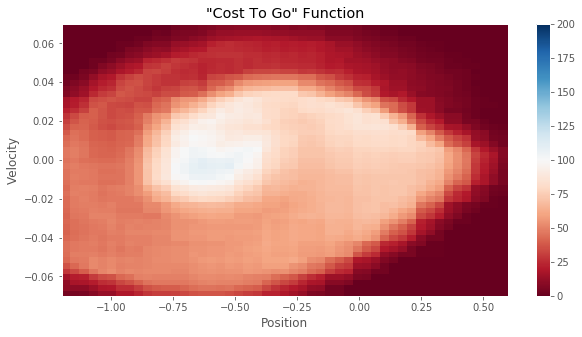

In [8]:
estimator_n = Estimator(alpha=0.5)
lengths_n, _ = run(sarsa_n, num_episodes=500, 
                       n=4, env=env, estimator=estimator_n, 
                       gamma=1, epsilon=0)
plotting.plot_cost_to_go(env, estimator_n)

Episode 500/500 Return -108.0)

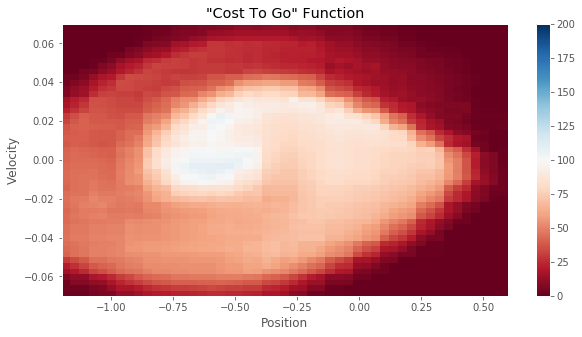

In [15]:
estimator_lambda = Estimator(alpha=0.5, trace=True)
lengths_lambda, _ = run(sarsa_lambda, num_episodes=500,
                    lmbda=0.92, env=env, estimator=estimator_lambda, 
                    gamma=1, epsilon=0)
plotting.plot_cost_to_go(env, estimator_lambda)

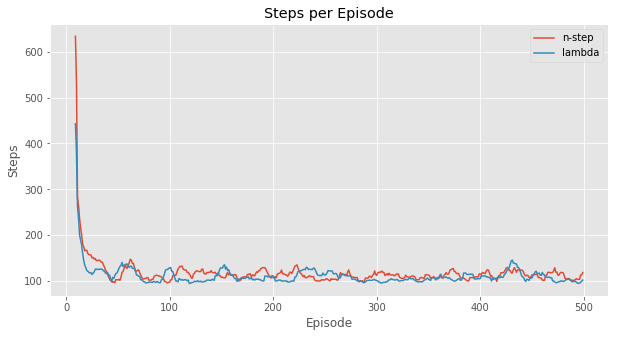

In [23]:
stats = {'n-step': lengths_n, 'lambda': lengths_lambda}
plotting.plot_learning_curves(stats)

In [32]:
alphas = np.arange(0.1, 1.8, 0.1)
ns = np.power(2, np.arange(0, 5))
run_grid_search(sarsa_n, env, alphas, ns, 
                trace=False)

In [ ]:
lambdas = np.array([0, 0.68, 0.84, 0.92, 0.98, 0.99])
run_grid_search(sarsa_n, env, alphas, lambdas, 
                trace=True):

## Plot learned policy

In [19]:
import time
env = gym.make("MountainCar-v0")  # Include step limit for validation
epsilon = 0
# The policy we're following
policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)
#for i_episide in range(20):
state = env.reset()
for t in itertools.count():
    time.sleep(0.01)
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    state, _, done, _ = env.step(action)
    env.render()
    if done:
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
